# Custom Modellig

In [61]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

def cls():
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()

In [62]:
house = fetch_california_housing()
x_train, x_test, y_train, y_test   = train_test_split(house.data, house.target, test_size=0.1, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

scaler, scaler2 = StandardScaler(), StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_test_s  = scaler.transform(x_test)
x_valid_s = scaler.transform(x_valid)

print("Independent variables : ", x_train_s.shape, x_valid_s.shape, x_test_s.shape)
print("Target variables      : ", y_train.shape, y_valid.shape, y_test.shape)

Independent variables :  (16718, 8) (1858, 8) (2064, 8)
Target variables      :  (16718,) (1858,) (2064,)


In [63]:
cls()
model = tf.keras.Sequential([tf.keras.layers.Dense(30, activation="elu", kernel_initializer="he_normal", input_shape=[x_train_s.shape[1]]),
                            tf.keras.layers.Dense(10, activation="elu"),
                            tf.keras.layers.Dense(1)])

model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=["mae"])
history = model.fit(x_train_s, y_train, epochs=4, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/4
523/523 [==============================] - 1s 2ms/step - loss: 0.4583 - mae: 0.7910 - val_loss: 0.2270 - val_mae: 0.5280
Epoch 2/4
523/523 [==============================] - 1s 1ms/step - loss: 0.1969 - mae: 0.4809 - val_loss: 0.2079 - val_mae: 0.4939
Epoch 3/4
523/523 [==============================] - 1s 1ms/step - loss: 0.1833 - mae: 0.4600 - val_loss: 0.1921 - val_mae: 0.4709
Epoch 4/4
65/65 [==============================] - 0s 1ms/step - loss: 0.1816 - mae: 0.4583


[0.18163689970970154, 0.4582922160625458]

### 1. Custom Loss function

In [78]:
# Lets create huber loss function
def huber_fun(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2 # Normalize MSE
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss) 


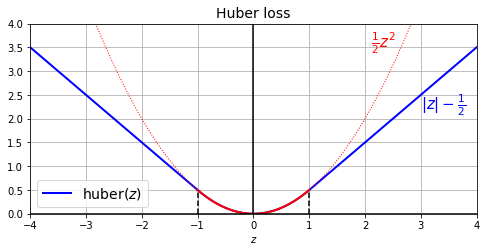

In [79]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
z_center = np.linspace(-1, 1, 200)
plt.plot(z, huber_fun(0, z), "b-", linewidth=2, label="huber($z$)")
plt.plot(z, z ** 2 / 2, "r:", linewidth=1)
plt.plot(z_center, z_center ** 2 / 2, "r", linewidth=2)
plt.plot([-1, -1], [0, huber_fun(0., -1.)], "k--")
plt.plot([1, 1], [0, huber_fun(0., 1.)], "k--")
plt.gca().axhline(y=0, color='k')
plt.gca().axvline(x=0, color='k')
plt.text(2.1, 3.5, r"$\frac{1}{2}z^2$", color="r", fontsize=15)
plt.text(3.0, 2.2, r"$|z| - \frac{1}{2}$", color="b", fontsize=15)
plt.axis([-4, 4, 0, 4])
plt.grid(True)
plt.xlabel("$z$")
plt.legend(fontsize=14)
plt.title("Huber loss", fontsize=14)
plt.show()

In [84]:
cls()
model.compile(loss=huber_fun, optimizer='adam', metrics=["mae"])
history = model.fit(x_train_s, y_train, epochs=4, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/4
523/523 [==============================] - 1s 2ms/step - loss: 0.1370 - mae: 0.3849 - val_loss: 0.1480 - val_mae: 0.4024
Epoch 2/4
523/523 [==============================] - 1s 1ms/step - loss: 0.1365 - mae: 0.3843 - val_loss: 0.1463 - val_mae: 0.4000
Epoch 3/4
523/523 [==============================] - 1s 1ms/step - loss: 0.1362 - mae: 0.3829 - val_loss: 0.1466 - val_mae: 0.4036
Epoch 4/4
65/65 [==============================] - 0s 828us/step - loss: 0.1445 - mae: 0.3964


[0.1445251703262329, 0.39644020795822144]

### 2. Saving/Loading with custom objects

In [85]:
model.save("model/model.h5")

In [90]:
# Need to pass all custom objects
temp = tf.keras.models.load_model("model/model.h5", custom_objects={"huber_fun":huber_fun})
temp.predict(x_test[[0]])

array([[195.63742]], dtype=float32)

In [91]:
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.1350 - mae: 0.3812 - val_loss: 0.1463 - val_mae: 0.3990
Epoch 2/2
65/65 [==============================] - 0s 794us/step - loss: 0.1420 - mae: 0.3940


[0.14201784133911133, 0.39404675364494324]

In [92]:
def create_huber(threshold=1.0):
    def huber_fun(y_true, y_pred):
        error = y_true-y_pred
        is_error_small = error < threshold
        squared_loss = tf.square(error)/2
        linear_loss  = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_error_small, squared_loss, linear_loss)
    return huber_fun

In [98]:
cls()
model.compile(loss=create_huber(2.), optimizer='adam', metrics=["mae"])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.1454 - mae: 0.3758 - val_loss: 0.1629 - val_mae: 0.3934
Epoch 2/2
65/65 [==============================] - 0s 946us/step - loss: 0.1552 - mae: 0.3916


[0.1551503688097, 0.3916175663471222]

In [99]:
model.save("model/model_2.h5")

In [104]:
# Need to specify threshold value manually
model2 = tf.keras.models.load_model("model/model_2.h5", custom_objects={"huber_fun":create_huber(2.)})

In [105]:
history = model2.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.1438 - mae: 0.3744 - val_loss: 0.1618 - val_mae: 0.3921
Epoch 2/2
65/65 [==============================] - 0s 1ms/step - loss: 0.1552 - mae: 0.3916


[0.1551503688097, 0.3916175663471222]

In [106]:
# We can solve this problem by implementing tf.keras.losses.Loss class and its get_config() function

class HuberLoss(tf.keras.losses.Loss):
    def __init__(self, threshold=1., **kwargs):
        self.threshold = threshold
        super().__init__(**kwargs)

    def call(self, y_true, y_pred): # This function called during training. You can do anything in this function
        error = y_true - y_pred
        is_error_small = error < self.threshold
        squared_loss = tf.square(error)/2
        linear_loss  = self.threshold * tf.abs(error) - self.threshold ** 2 / 2
        return tf.where(is_error_small, squared_loss, linear_loss)
    
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold":self.threshold}
        

In [107]:
cls()
model.compile(loss=HuberLoss(2.), optimizer='adam', metrics=["mae"])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.1449 - mae: 0.3752 - val_loss: 0.1624 - val_mae: 0.3926
Epoch 2/2
65/65 [==============================] - 0s 960us/step - loss: 0.1548 - mae: 0.3910


[0.15481024980545044, 0.39101728796958923]

In [108]:
model.save("model/model_custom_class.h5")

In [109]:
# Model running fine without pass explicit threshold value
model3 = tf.keras.models.load_model('model/model_custom_class.h5', custom_objects={"HuberLoss":HuberLoss})
history = model3.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)


Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.1434 - mae: 0.3738 - val_loss: 0.1611 - val_mae: 0.3912
Epoch 2/2
65/65 [==============================] - 0s 960us/step - loss: 0.1548 - mae: 0.3910


[0.15481024980545044, 0.39101728796958923]

In [112]:
model.loss.get_config()

{'reduction': 'auto', 'name': None, 'threshold': 2.0}

### 3. Custom Activation function, Initializers, Regularizers, Constraints, and Optimizers

In [117]:
# softplus activation function
def my_softplus(z):
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorat(shape, dtype=tf.float32):
    stddev = tf.sqrt(2./(shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

# 0.01 regularize threshold
def my_l1_regularize(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights)) 

# return value is just tf.nn.relu(weights)
def my_positive_weights(weights): 
    return tf.where(weights<0.,tf.zeros_like(weights), weights)


In [118]:
l =tf.keras.layers.Dense(1,activation=my_softplus,kernel_initializer=my_glorat,kernel_regularizer=my_l1_regularize,kernel_constraint=my_positive_weights)

In [121]:
# Lets build one model again
cls()
model = tf.keras.models.Sequential([tf.keras.layers.Dense(30, kernel_initializer=my_glorat, input_shape=(x_train_s.shape[1:])),
                                    tf.keras.layers.Dense(10, activation=my_softplus,
                                                            kernel_initializer=my_glorat, 
                                                            kernel_regularizer=my_l1_regularize, 
                                                            kernel_constraint=my_positive_weights),
                                    tf.keras.layers.Dense(1)])

model.compile(loss=HuberLoss(2.), optimizer="adam", metrics=['mae'])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 1.6073 - mae: 1.3172 - val_loss: 0.5062 - val_mae: 0.5759
Epoch 2/2
65/65 [==============================] - 0s 843us/step - loss: 0.4028 - mae: 0.5240


[0.40281733870506287, 0.5240435600280762]

In [122]:
model.save("model/model_custom_kernels.h5")
co = {"my_glorat":my_glorat,"my_softplus":my_softplus,"my_l1_regularize":my_l1_regularize,"my_positive_weights":my_positive_weights,"HuberLoss":HuberLoss}
model4 = tf.keras.models.load_model("model/model_custom_kernels.h5", custom_objects=co)
history = model4.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model4.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.3616 - mae: 0.4979 - val_loss: 0.3649 - val_mae: 0.5126
Epoch 2/2
65/65 [==============================] - ETA: 0s - loss: 0.3230 - mae: 0.496 - 0s 938us/step - loss: 0.3233 - mae: 0.4975


[0.3233291208744049, 0.4975474774837494]

In [125]:
# If we want to build with custom hyperparameters
################################################################################################################################################
# We must implement __call__() method for regularizers, initializers, and constraints parent class do not define get_config() function as well #
# and implement call() for losses, layers(including activation functions), and models                                                          #
################################################################################################################################################
class MyL1Regular(tf.keras.regularizers.Regularizer):
    def __init__(self, threshold, **kwargs):
        self.threshold = threshold
        # Not calling parent class's constructor
    def __call__(self, weights):
        return tf.reduce_sum(tf.abs(self.threshold*weights))
    def get_config(self):
        return {"threshold":self.threshold}

In [126]:
# Lets build one model again
cls()
model = tf.keras.models.Sequential([tf.keras.layers.Dense(30, kernel_initializer=my_glorat, input_shape=(x_train_s.shape[1:])),
                                    tf.keras.layers.Dense(10, activation=my_softplus,
                                                            kernel_initializer=my_glorat, 
                                                            kernel_regularizer=MyL1Regular(0.02), 
                                                            kernel_constraint=my_positive_weights),
                                    tf.keras.layers.Dense(1)])

model.compile(loss=HuberLoss(2.), optimizer="adam", metrics=['mae'])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.save("model/model_custom_class_kernels.h5")
co = {"my_glorat":my_glorat,"my_softplus":my_softplus,"MyL1Regular":MyL1Regular,"my_positive_weights":my_positive_weights,"HuberLoss":HuberLoss}
model5 = tf.keras.models.load_model("model/model_custom_class_kernels.h5", custom_objects=co)
# Retraining to check whether it is working or not
history = model5.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model5.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 1ms/step - loss: 1.7757 - mae: 1.3462 - val_loss: 0.5867 - val_mae: 0.5782
Epoch 2/2
523/523 [==============================] - 1s 1ms/step - loss: 0.4763 - mae: 0.5345 - val_loss: 0.4368 - val_mae: 0.5324
Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.3721 - mae: 0.5075 - val_loss: 0.3624 - val_mae: 0.5191
Epoch 2/2
65/65 [==============================] - 0s 976us/step - loss: 0.3236 - mae: 0.5031


[0.3235660493373871, 0.5030665397644043]

In [329]:
################################################################
# Skip this for instance: come back here after 9. custom model #
# To better understanding TO build custom optimizers           #
################################################################
class MyMomentumOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, momentum=0.9, name="MyMomentumOptimizer", **kwargs):
        """Call super().__init__() and use _set_hyper() to store hyperparameters"""
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate)) # handle lr=learning_rate
        self._set_hyper("decay", self._initial_decay) # 
        self._set_hyper("momentum", momentum)
    
    def _create_slots(self, var_list):
        """For each model variable, create the optimizer variable associated with it.
        TensorFlow calls these optimizer variables "slots".
        For momentum optimization, we need one momentum slot per model variable.
        """
        for var in var_list:
            self.add_slot(var, "momentum")

    @tf.function
    def _resource_apply_dense(self, grad, var):
        """Update the slots and perform one optimization step for one model variable
        """
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        momentum_var = self.get_slot(var, "momentum")
        momentum_hyper = self._get_hyper("momentum", var_dtype)
        momentum_var.assign(momentum_var * momentum_hyper - (1. - momentum_hyper)* grad)
        var.assign_add(momentum_var * lr_t)

    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
            "decay": self._serialize_hyperparameter("decay"),
            "momentum": self._serialize_hyperparameter("momentum"),
        }


In [330]:
cls()
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[8])])
model.compile(loss="mse", optimizer=MyMomentumOptimizer())
model.fit(x_train_s, y_train, epochs=5)

Epoch 1/5
523/523 [==============================] - 1s 607us/step - loss: 3.1587
Epoch 2/5
523/523 [==============================] - 0s 661us/step - loss: 1.0364
Epoch 3/5
523/523 [==============================] - 0s 556us/step - loss: 0.7367
Epoch 4/5
523/523 [==============================] - 0s 572us/step - loss: 0.6734
Epoch 5/5
523/523 [==============================] - 0s 596us/step - loss: 0.6465


### 4. Custom Metrics
 Defining the custom metrics exactly the same as defining the loss function

In [127]:
model.compile(loss=create_huber(2.), optimizer='adam', metrics=[create_huber(2.)])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.3494 - huber_fun: 0.2392 - val_loss: 0.3414 - val_huber_fun: 0.2542
Epoch 2/2
65/65 [==============================] - 0s 957us/step - loss: 0.3107 - huber_fun: 0.2374


[0.31067290902137756, 0.237367644906044]

Note: if you use the same function as the loss and a metric, you may be surprised to see slightly different results. This is in part because the operations are not computed exactly in the same order, so there might be tiny floating point errors. More importantly, if you use sample weights or class weights, then the equations are a bit different:

- the fit() method keeps track of the mean of all batch losses seen so far since the start of the epoch. Each batch loss is the sum of the weighted instance losses divided by the batch size (not the sum of weights, so ***the batch loss is not the weighted mean of the losses***).
- the metric since the start of the epoch is equal to the sum of weighted instance losses divided by sum of all weights seen so far. In other words, it is ***the weighted mean of all the instance losses. Not the same thing***.

When we need to keep track the mean loss or mean accuracy in epoch during batch run we implement something called **Streaming metrics**

In [139]:
cls()
class HuberMetric(tf.keras.metrics.Metric):
    def __init__(self, threshold=1.0, **kwargs):
        super().__init__(**kwargs) # Handle base arguments like (eg: dtypes)
        self.threshold = threshold
        self.huber_fn  = create_huber(threshold)
        self.total     = self.add_weight("total", initializer="zeros")
        self.count     = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        return self.total/ self.count

    def get_config(self):
        return {**super().get_config(), "threshold":self.threshold} 

In [140]:
m = HuberMetric(2.)

# total = 2 * |10 - 2| - 2²/2 = 14
# count = 1
# result = 14 / 1 = 14
m(tf.constant([[2.]]), tf.constant([[10.]]))

<tf.Tensor: shape=(), dtype=float32, numpy=32.0>

In [141]:
# total = total + (|1 - 0|² / 2) + (2 * |9.25 - 5| - 2² / 2) = 14 + 7 = 21
# count = count + 2 = 3
# result = total / count = 21 / 3 = 7
m(tf.constant([[0.], [5.]]), tf.constant([[1.], [9.25]]))

<tf.Tensor: shape=(), dtype=float32, numpy=13.84375>

In [142]:
m.result()

<tf.Tensor: shape=(), dtype=float32, numpy=13.84375>

In [143]:
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=41.53125>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [144]:
m.reset_states()
m.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [145]:
# Lets check metrics custom class working or not
model.compile(loss=HuberLoss(2.), optimizer='adam', metrics=[HuberMetric(2.)])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 3s 2ms/step - loss: 0.2860 - huber_metric_1: 0.2214 - val_loss: 0.3025 - val_huber_metric_1: 0.2439
Epoch 2/2
65/65 [==============================] - 0s 1ms/step - loss: 0.2839 - huber_metric_1: 0.2319


[0.28389590978622437, 0.2319127470254898]

In [147]:
model.save("model/model_custom_metric_kernels.h5")
co = {"my_glorat":my_glorat,
        "my_softplus":my_softplus,
        "MyL1Regular":MyL1Regular,
        "my_positive_weights":my_positive_weights,
        "HuberLoss":HuberLoss,
        "HuberMetric":HuberMetric}
model6 = tf.keras.models.load_model("model/model_custom_metric_kernels.h5", custom_objects=co)
# Retraining to check whether it is working or not
history = model6.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
model5.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.2682 - huber_metric_1: 0.2173 - val_loss: 0.2899 - val_huber_metric_1: 0.2419
Epoch 2/2
65/65 [==============================] - 0s 1ms/step - loss: 0.3236 - mae: 0.5031


[0.3235660493373871, 0.5030665397644043]

`model.metrics` contains the model's loss followed by the model's metric(s), so the `HuberMetric` is `model.metrics[-1]`:

In [157]:
model6.metrics[-1], model6.metrics[-1].threshold

(<__main__.HuberMetric at 0x21064ff7460>, 2.0)

In [181]:
# We can also create the above class like this:
cls()
class HuberMetric(tf.keras.metrics.Mean):
    def __init__(self, threshold=1.0, name='HuberMetric', dtype=None):
        self.threshold = threshold
        self.huber_fn = create_huber(threshold)
        super().__init__(name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        super(HuberMetric, self).update_state(metric, sample_weight)

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}   

In [187]:
# Lets build one model again
cls()
model = tf.keras.models.Sequential([tf.keras.layers.Dense(30, kernel_initializer=my_glorat, input_shape=(x_train_s.shape[1:])),
                                    tf.keras.layers.Dense(10, activation=my_softplus,
                                                            kernel_initializer=my_glorat, 
                                                            kernel_regularizer=MyL1Regular(0.02), 
                                                            kernel_constraint=my_positive_weights),
                                    tf.keras.layers.Dense(1)])

model.compile(loss=HuberLoss(2.), optimizer="adam", metrics=[HuberMetric(2.0)])
sample_weights = tf.random.uniform([len(y_train)], 0, 1)
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid), sample_weight=sample_weights)

#model.save("model/model_custom_class_metrics.h5")
#co = {"my_glorat":my_glorat,"my_softplus":my_softplus,"MyL1Regular":MyL1Regular,"my_positive_weights":my_positive_weights,"HuberLoss":HuberLoss}
# model5 = tf.keras.models.load_model("model/model_custom_class_metrics.h5", custom_objects=co)
# # Retraining to check whether it is working or not
# history = model5.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
# model5.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 1.0166 - HuberMetric: 1.5222 - val_loss: 0.4716 - val_HuberMetric: 0.3186
Epoch 2/2
523/523 [==============================] - 1s 1ms/step - loss: 0.2426 - HuberMetric: 0.2736 - val_loss: 0.3575 - val_HuberMetric: 0.2863


In [193]:
(history.history["loss"][0], history.history["HuberMetric"][0] * tf.reduce_mean(sample_weights))

(1.0165752172470093, <tf.Tensor: shape=(), dtype=float32, numpy=0.762183>)

### 5. Custom Layer
We may occasionally want to build an architecture that contains block or layer or repeated layers like ABCD ABCD ABCD in that scenario we can create the custom layer as well

In [198]:
exp_layer = tf.keras.layers.Lambda(lambda x: tf.exp(x))

In [200]:
# we can use layers as a function also
exp_layer(3.)

<tf.Tensor: shape=(), dtype=float32, numpy=20.085537>

In [201]:
# Sample
cls()
model = tf.keras.models.Sequential([tf.keras.layers.Dense(30,input_shape=(x_train_s.shape[1:])),
                                    tf.keras.layers.Dense(1),
                                    exp_layer])

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))

Epoch 1/2
523/523 [==============================] - 1s 1ms/step - loss: 0.8528 - mae: 0.6322 - val_loss: 0.6336 - val_mae: 0.5701
Epoch 2/2
523/523 [==============================] - 0s 879us/step - loss: 0.5675 - mae: 0.5442 - val_loss: 0.5856 - val_mae: 0.5510


In [203]:
# Simple layer
class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(name="kernel", shape=[batch_input_shape[-1], self.units], initializer="he_normal")
        self.bias = self.add_weight(name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape)  # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units, "activation": tf.keras.activations.serialize(self.activation)}

In [205]:
# Sample
cls()
model = tf.keras.models.Sequential([MyDense(30,activation="relu", input_shape=(x_train_s.shape[1:])),
                                    MyDense(1),
                                    exp_layer])

model.compile(loss="mse", optimizer="adam", metrics=["mae"])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))

# We cannot write model in h5 format while include custom layers
save_path = "model/model_custom_layer" 
model.save(save_path)

co = {"MYDense":MyDense,"exp_layer":exp_layer}
new_model = tf.keras.models.load_model(save_path, custom_objects=co)
history = new_model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
new_model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 1ms/step - loss: 1.2230 - mae: 0.7961 - val_loss: 0.6848 - val_mae: 0.5939
Epoch 2/2
523/523 [==============================] - 0s 787us/step - loss: 0.5376 - mae: 0.5344 - val_loss: 0.5389 - val_mae: 0.5321
INFO:tensorflow:Assets written to: model/model_custom_layer\assets
Epoch 1/2
523/523 [==============================] - 1s 1ms/step - loss: 0.4473 - mae: 0.4815 - val_loss: 0.4694 - val_mae: 0.4939
Epoch 2/2
65/65 [==============================] - 0s 608us/step - loss: 0.4453 - mae: 0.4701


[0.4452732503414154, 0.4700668156147003]

In [213]:
# Layer with multi output
class MyMultiLayer(tf.keras.layers.Layer):
    def call(self, X):
        X1, X2 = X
        print("X1.shape: ", X1.shape ," X2.shape: ", X2.shape)  # extra code
        return X1 + X2, X1 * X2, X1 / X2

    def compute_output_shape(self, batch_input_shape):
        batch_input_shape1, batch_input_shape2 = batch_input_shape
        return [batch_input_shape1, batch_input_shape1, batch_input_shape1]

In [216]:
# We can also use custom layer as functional API
cls()
l1 = tf.keras.layers.Input(shape=[2])
l2 = tf.keras.layers.Input(shape=[2])
MyMultiLayer()((l1, l2))


X1.shape:  (None, 2)  X2.shape:  (None, 2)


(<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'my_multi_layer')>)

In [217]:
# You can pass actual data as well
X1, X2 = np.array([[3., 6.], [2., 7.]]), np.array([[6., 12.], [4., 3.]]) 
MyMultiLayer()((X1, X2))

X1.shape:  (2, 2)  X2.shape:  (2, 2)


(<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[ 9., 18.],
        [ 6., 10.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[18., 72.],
        [ 8., 21.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[0.5      , 0.5      ],
        [0.5      , 2.3333333]], dtype=float32)>)

In [219]:
# If our layers have different behavior during training and testing like dropout, BatchNormalization in that case we add training argument in call()

class MyGaussianNoise(tf.keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [220]:
# Sample
cls()
model = tf.keras.models.Sequential([MyGaussianNoise(1., input_shape=(x_train_s.shape[1:])),
                                    MyDense(30,activation="relu"),
                                    MyDense(1),
                                    exp_layer])
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))

Epoch 1/2
523/523 [==============================] - 1s 1ms/step - loss: 2.7081 - mae: 1.1351 - val_loss: 1.5782 - val_mae: 0.9394
Epoch 2/2
523/523 [==============================] - 0s 904us/step - loss: 1.6358 - mae: 0.9626 - val_loss: 1.2550 - val_mae: 0.8148


### 6. Custom Models

Its also straightforward create the subclass of `tf.keras.Model` create layers, and variables in the constructor, and implement call()

In [229]:
#Lets build a model that contains a skip connection block
# It is a block
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_layers, n_neurons, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu", kernel_initializer="he_normal") for _ in range(n_layers)]

    def call(self, inputs):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        return inputs + Z
    

In [230]:
# This is model which use residualblock
class ResidualRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        self.block1 = ResidualBlock(2, 30)
        self.block2 = ResidualBlock(2, 30)
        self.out = tf.keras.layers.Dense(output_dim)

    def call(self, inputs):
        Z = self.hidden1(inputs)
        for _ in range(1 + 3):
            Z = self.block1(Z)
        Z = self.block2(Z)
        return self.out(Z)

In [235]:
cls()
model = ResidualRegressor(1)
model.compile(loss="mse", optimizer="adam", metrics=["mae"])
history = model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))

save_path = "model/model_custom_model" 
model.save(save_path)

new_model = tf.keras.models.load_model(save_path)
history = new_model.fit(x_train_s, y_train, epochs=2, validation_data=(x_valid_s, y_valid))
new_model.evaluate(x_test_s, y_test)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 3.1743 - mae: 1.0238 - val_loss: 0.8021 - val_mae: 0.6305
Epoch 2/2
523/523 [==============================] - 1s 2ms/step - loss: 0.6809 - mae: 0.5977 - val_loss: 0.8468 - val_mae: 0.6367


INFO:tensorflow:Assets written to: model/model_custom_model\assets


INFO:tensorflow:Assets written to: model/model_custom_model\assets


Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 1.0686 - mae: 0.6106 - val_loss: 0.5626 - val_mae: 0.5358
Epoch 2/2
65/65 [==============================] - 0s 1ms/step - loss: 0.5094 - mae: 0.5095


[0.5093919634819031, 0.5095109343528748]

In [237]:
# We can also build model like sequentially
cls()
block1 = ResidualBlock(2, 30)
model_ = tf.keras.Sequential([
    tf.keras.layers.Dense(30, activation="relu",kernel_initializer="he_normal", input_shape=[x_train.shape[1]]),
    block1, 
    block1, 
    block1, 
    block1,
    ResidualBlock(2, 30),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "residual_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  270       
_________________________________________________________________
residual_block (ResidualBloc multiple                  1860      
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  1860      
_________________________________________________________________
dense_5 (Dense)              multiple                  31        
Total params: 4,021
Trainable params: 4,021
Non-trainable params: 0
_________________________________________________________________


We can now as of build model custom MLP model.

### 7. Losses & Metrics Based on Model Internals
Till now we define loss and metrics function based on labels and the predictions (and optionally sample weights). If we want to define losses based on other parts of our model, such as the weights or activations of its hidden layers. this may be useful for regularization purposes or to monitor some internal aspect of our model.

In [240]:
class ReconstructingRegressor(tf.keras.Model):
    def __init__(self, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.hidden = [tf.keras.layers.Dense(30, activation="relu") for _ in range(5)] # 5 hidden layers
        self.out = tf.keras.layers.Dense(output_dim) # 1 output layer
        self.reconstruction_mean = tf.keras.metrics.Mean(name="reconstruction_error")

    def build(self, batch_input_shape):
        n_inputs = batch_input_shape[-1]
        self.reconstruct = tf.keras.layers.Dense(n_inputs)
        self.built = True  # WORKAROUND for super().build(batch_input_shape) <--- this throughing error right now

    def call(self, inputs, training=None):
        Z = inputs
        for layer in self.hidden:
            Z = layer(Z)
        reconstruction = self.reconstruct(Z)
        recon_loss = tf.reduce_mean(tf.square(reconstruction - inputs))
        self.add_loss(0.05 * recon_loss)
        if training:
            result = self.reconstruction_mean(recon_loss)
            self.add_metric(result)
        return self.out(Z)

In [241]:
cls()
model = ReconstructingRegressor(1)
model.compile(loss="mse", optimizer="adam")
history = model.fit(x_train_s, y_train, epochs=2)
y_pred = model.predict(x_test_s)

Epoch 1/2
523/523 [==============================] - 1s 2ms/step - loss: 0.7760 - reconstruction_error: 0.8690
Epoch 2/2
523/523 [==============================] - 1s 2ms/step - loss: 0.4140 - reconstruction_error: 0.6491


### 8. Computing Gradients using AutoDiff

In [251]:
def f(w1, w2):
    return 3 * w1 ** 2 + 2 * w1 * w2

w1, w2 = 5, 5
eps = 1e-6
(f(w1 + eps, w2) - f(w1, w2)) / eps


40.00000301118689

In [252]:
(f(w1, w2 + eps) - f(w1, w2)) / eps

10.000000003174137

In [262]:
w1, w2 = tf.Variable(5.), tf.Variable(5.)
with tf.GradientTape() as tape:
    z = f(w1, w2)

# You can call tape.gradient() only once
gradients = tape.gradient(z, [w1, w2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=40.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [263]:
with tf.GradientTape() as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 40.0
try:
    dz_dw2 = tape.gradient(z, w2)  # raises a RuntimeError!
except RuntimeError as ex:
    print(ex)

A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)


In [264]:
# Use persistent=True if you want to use tape.gradient multiple times
with tf.GradientTape(persistent=True) as tape:
    z = f(w1, w2)

dz_dw1 = tape.gradient(z, w1)  # returns tensor 40.0
dz_dw2 = tape.gradient(z, w2)  # returns tensor 10.0, works fine now!
del tape

In [265]:
dz_dw1, dz_dw2

(<tf.Tensor: shape=(), dtype=float32, numpy=40.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>)

In [270]:
# Tensor will not track the gradient of constant it only track the gradient of variables by default
c1, c2 = tf.constant(5.), tf.constant(5.)
with tf.GradientTape() as tape:
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[None, None]

In [271]:
# We have to call tape.watch() to track the gradient of constants
with tf.GradientTape() as tape:
    tape.watch(c1)
    tape.watch(c2)
    z = f(c1, c2)

gradients = tape.gradient(z, [c1, c2])
gradients

[<tf.Tensor: shape=(), dtype=float32, numpy=40.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=10.0>]

In [288]:
fx    = lambda x: 2*x**2 # This is f(x) = 2x^2 df(x)/dx = 4x, at x=10, df(10)/dx = 4*10 = 40 
a1,a2 = tf.Variable(10.), tf.Variable(20.)
with tf.GradientTape() as tape:
    z1 = fx(a1)
    z2 = fx(a2)
tape.gradient([z1, z2], [a1, a2])


[<tf.Tensor: shape=(), dtype=float32, numpy=40.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=80.0>]

In [290]:
# if given a vector, tape.gradient() will compute the gradient of the vector's sum.
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)

tape.gradient([z1, z2, z3], [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=148.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [291]:
# shows that we get the same result as the previous cell
with tf.GradientTape() as tape:
    z1 = f(w1, w2 + 2.)
    z2 = f(w1, w2 + 5.)
    z3 = f(w1, w2 + 7.)
    z = z1 + z2 + z3

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=148.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=30.0>]

In [293]:
#shows how to compute the jacobians and the hessians
fx    = lambda x: 2*x**2 # This is f(x) = 2x^2 df(x)/dx = 4x, at x=10, df(10)/dx = 4*10 = 40 
a1,a2 = tf.Variable(10.), tf.Variable(20.)

with tf.GradientTape(persistent=True) as hessian_tape:
    with tf.GradientTape() as jacobian_tape:
        z1 = fx(a1)
        z2 = fx(a2)
    jacobians = jacobian_tape.gradient([z1, z2], [a1, a2])
hessians = [hessian_tape.gradient(jacobian, [a1, a2]) for jacobian in jacobians]

In [294]:
jacobians

[<tf.Tensor: shape=(), dtype=float32, numpy=40.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=80.0>]

In [295]:
hessians

[[<tf.Tensor: shape=(), dtype=float32, numpy=4.0>, None],
 [None, <tf.Tensor: shape=(), dtype=float32, numpy=4.0>]]

In [299]:
# If we want to stop gradient for some layers during backpropagation we can do this by using stop_gradient()
def f(w1, w2):
    # It will not calculate the derivative w.r.t (y)
    return 3 * w1 ** 2 + tf.stop_gradient(2 * w1 * w2)  # 3x^2 + 2xy
    #return 3 * w1 ** 2 + (2 * w1 * w2)  # 3x^2 + 2xy

with tf.GradientTape() as tape:
    z = f(w1, w2)  # same result as without stop_gradient()

tape.gradient(z, [w1, w2])

[<tf.Tensor: shape=(), dtype=float32, numpy=30.0>, None]

In [300]:
# In some case our gradient tend to zeros for softplus or sigmoid function when input tends to zero or you do not change the weights
x = tf.Variable(1e-50)
with tf.GradientTape() as tape:
    z = tf.sqrt(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(), dtype=float32, numpy=inf>]

In [302]:
# But calculating derivative or sigmoid is analytically feasible.
tf.math.log(tf.exp(tf.constant(30., dtype=tf.float32)) + 1.)

<tf.Tensor: shape=(), dtype=float32, numpy=30.0>

In [306]:
def my_softplus(z):
    return tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)

x = tf.Variable([1.0e30])
with tf.GradientTape() as tape:
    z = my_softplus(x)

tape.gradient(z, [x])

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]

In [307]:
# Decorate tensorflow custom_gradient function
@tf.custom_gradient
def my_softplus(z):
    def my_softplus_gradients(grads):  # grads = backprop'ed from upper layers
        return grads * (1 - 1 / (1 + tf.exp(z)))  # stable grads of softplus

    result = tf.math.log(1 + tf.exp(-tf.abs(z))) + tf.maximum(0., z)
    return result, my_softplus_gradients

In [308]:
x = tf.Variable([1000.])
with tf.GradientTape() as tape:
    z = my_softplus(x)

z, tape.gradient(z, [x])

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1000.], dtype=float32)>,
 [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>])

### 9. Custom Training Loops

Wide & Deep paper uses two different optimizers: one for the wide path and the other for the deep path. Since the `fit()` method only uses one optimizer.

In [309]:
# First, build the simple model
cls()
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dense(1)])

In [310]:
def random_batch(X, y, batch_size=32):
    idx = np.random.randint(len(X), size=batch_size)
    return X[idx], y[idx]

In [320]:
def print_status_bar(step, total, loss, metrics=None):
    metrics = " - ".join([f"{m.name}: {m.result():.4f}" for m in [loss] + (metrics or [])])
    end = "" if step < total else "\n"
    print(f"\r{step}/{total} - " + metrics, end=end) # \r is carriage return will ensure that the print statement execute on same line

In [321]:
n_epochs = 5
batch_size = 32
n_steps = len(x_train) // batch_size
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn   = tf.keras.losses.mean_squared_error
mean_loss = tf.keras.metrics.Mean()
metrics   = [tf.keras.metrics.MeanAbsoluteError()]

In [322]:
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}/{n_epochs}")
    for step in range(1, n_steps + 1):
        X_batch, y_batch = random_batch(x_train_s, y_train)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch, training=True)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses) # model loss basically regularization loss that we add in main loss

        gradients = tape.gradient(loss, model.trainable_variables)
        
        # If you want to do any transformation with gradient you can do before the apply_gradients()
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        #if your model has variable constraints
        for variable in model.variables:
            if variable.constraint is not None:
                variable.assign(variable.constraint(variable))

        mean_loss(loss)
        for metric in metrics:
            metric(y_batch, y_pred)

        print_status_bar(step, n_steps, mean_loss, metrics)

    for metric in [mean_loss] + metrics:
        metric.reset_states()

Epoch 1/5
522/522 - mean: 3.9725 - mean_absolute_error: 0.9552
Epoch 2/5
522/522 - mean: 2.1014 - mean_absolute_error: 0.8969
Epoch 3/5
522/522 - mean: 1.5703 - mean_absolute_error: 0.8890
Epoch 4/5
522/522 - mean: 1.4374 - mean_absolute_error: 0.8994
Epoch 5/5
522/522 - mean: 1.3838 - mean_absolute_error: 0.9034


In [324]:
#Shows how to use the tqdm package to display nice progress bars

from tqdm.notebook import trange
from collections import OrderedDict
with trange(1, n_epochs + 1, desc="All epochs") as epochs:
    for epoch in epochs:
        with trange(1, n_steps + 1, desc=f"Epoch {epoch}/{n_epochs}") as steps:
            for step in steps:
                X_batch, y_batch = random_batch(x_train_s, y_train)
                with tf.GradientTape() as tape:
                    y_pred = model(X_batch)
                    main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
                    loss = tf.add_n([main_loss] + model.losses)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))

                for variable in model.variables:
                    if variable.constraint is not None:
                        variable.assign(variable.constraint(variable))

                status = OrderedDict()
                mean_loss(loss)
                status["loss"] = mean_loss.result().numpy()
                for metric in metrics:
                    metric(y_batch, y_pred)
                    status[metric.name] = metric.result().numpy()

                steps.set_postfix(status)

        for metric in [mean_loss] + metrics:
            metric.reset_states()

All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/522 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/522 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/522 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/522 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/522 [00:00<?, ?it/s]